In [1]:
import pybaseball as pyb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# 득점 가치 (Run Value) 측정

   
**2루타의 득점 가치는 어느정도일까? 2루타는 1루타보다 2배의 가치를 가졌을까?**   

야구에서 득점과 관련된 가치, Run Value를 측정해보았다. Run Value는 어떤 이벤트에 대한 전과 후의 득점 기대값 차이로 계산된다. 타자가 안타를 쳤다면, 안타를 치기 전과 친 후의 득점 기대값 차이가 그 안타의 Run Value가 된다.
   
그러면 득점 기대값(Run Expectancy)은 무엇일까? 득점 기대값은 현재 상황에서 이닝이 종료될 때 까지 몇 점을 득점할 수 있을지에 대한 기대값이다. 리그 전체로 보았을 때, 1아웃 1루주자 상황에서 이닝이 종료될 때 까지 평균적으로 득점이 0.5점 이루어졌다면, 1아웃 1루주자 상황의 득점 기대값은 0.5이다. 어떤 이벤트에 의해 타자의 타석이 종료되면, 아웃이 추가되던 주자 위치가 바뀌던 상황이 변화하게 되고, 이 변화된 상황과 이전 상황의 득점 기대값 차이가 Run Value이다.   
   
Run Value 계산을 통해 타석에서 이루어지는 각 이벤트들의 가치에 대해 평가하였다. 이벤트별 가치 측정과 함께, 선수들의 타석에서 이루어진 Run Value를 합산하여 선수들의 누적 Run Value를 계산하였다. 선수들의 누적 Run Value는 그 선수가 득점에 얼마나 관여하였는지를 보여주는 지표로 활용될 수 있다. 또한, 각 팀의 모든 타석에 대한 Run Value를 합산하여 팀별 누적 Run Value를 계산하였다. 야구는 득점을 더 많이 하는 팀이 이기는 게임이기 때문에, 팀별 누적 Run Value와 승률의 상관 관계에 대하여 분석해보았다.

### **- [0. Data ](#data)**
- 19시즌과 21시즌의 MLB Statcast 데이터를 이용하였다. 이벤트가 발생한 타석에 대한 데이터만을 추출하여, 각 타석에서의 상황과 득점과 관련된 데이터를 계산하였다.

### **- [1. Run Expectancy](#situation)**
- 야구에 존재하는 모든 상황(아웃카운트, 주자상황)에 대하여 득점 기대값을 측정하였다. 득점 기대값은 각 상황에서, 이닝이 종료될때까지 몇 점을 득점할 수 있을지에 대한 기대값이다. 예를 들어 1아웃 1루,2루 주자 상황에서의 득점 기대값은 약 0.88이다. 이것은 1아웃 1루,2루 주자 상황이 된다면, 그 이닝에 평균적으로 0.88의 득점을 할 수 있을 것이라는 예측을 할 수 있게 한다.
    

### **- [2. 이벤트 Run Value](#event)**
- 타자가 타석에 들어서고(Start_State) 어떤 이벤트에 의해 타석이 종료(End_State)된다. 이벤트에 의해 타석이 종료되기 까지 Start_State와 End_State 사이의 득점 기대값의 변화가 그 타석에서의 Run Value이다. 타석에서 발생할 수 있는 각 이벤트 별로 Run Value 평균값을 측정하여 이벤트의 가치를 비교하였다.
       
       
### **- [3. 선수별 Run Value 분석](#player)**
- Run Value를 선수(타자)별로 측정하였다. 각 타자가 등장했던 모든 타석에서의 Run Value을 합산하여 선수의 누적 Run Value를 측정하였다. 
- 선수별 누적 Run Value의 분포도를 시각화하여 확인하였다.
- 21시즌의 선수별 누적 득점 기회와 Run Value를 시각화하여 기회대비 활약을 확인하였다.
- 타자 각각의 상황별 Run Value를 확인하여 어떤 상황에서 활약하였는지 확인하였다. 토론토 블루제이스 타자 몇명을 예시로 하였다.
- Run Value와 타자들의 다른 Stat과의 관계성에 대해 시각화하였다.

### **- [4. 팀별 누적 Run Value](#team)**
- Run Value를 팀별로 측정하였다. 각 팀의 모든 타석에서의 Run Value을 합산하여 팀의 누적 Run Value를 측정하였다. 
- 팀의 Run Value와 팀의 승률의 상관 관계에 대해 분석하였다.

----

<a id="data"></a>
# 0. Data

In [2]:
mlb_21=pyb.statcast('2021-04-01', '2021-10-03')

This is a large query, it may take a moment to complete


100%|██████████| 186/186 [02:49<00:00,  1.10it/s]


In [3]:
mlb_19=pyb.statcast('2019-03-20', '2019-09-29')

This is a large query, it may take a moment to complete


100%|██████████| 194/194 [02:51<00:00,  1.13it/s]


In [4]:
event_21 = mlb_21[mlb_21['events'].notnull()]
event_19 = mlb_19[mlb_19['events'].notnull()]

In [5]:
def calculation(event):
    total_game = pd.DataFrame()
    game_id = np.array(event['game_pk'].unique())
    for i in game_id:
        game = event[event['game_pk']==i]
        # 타석 순으로 정리
        game = game.sort_values(by='at_bat_number')

        # Start에서
        # 1B, 2B, 3B에 주자가 없을 경우, 0으로
        # 1B, 2B, 3B가 주자가 있을 경우, 1으로
        game['Start1'] = np.where(game['on_1b'].isnull(),0,1)
        game['Start2'] = np.where(game['on_2b'].isnull(),0,1)
        game['Start3'] = np.where(game['on_3b'].isnull(),0,1)

        # Start 주자 상황과 아웃카운트 병합
        game['Start_State'] = (game['Start1'].astype(str) + game['Start2'].astype(str) + game['Start3'].astype(str)+" " + game['outs_when_up'].astype(str))


        # End에서
        # 아웃카운트 계산 (이닝이 종료되었을 경우 3)
        game['end_out'] = game['outs_when_up'].shift(-1)
        game['end_out'] = np.where(game['end_out'].isnull(), 3, game['end_out'])
        game['end_out'] = np.where(((game['end_out']==0) & (game['outs_when_up']!=0)), 3, game['end_out'])

        # End에서
        # 1B, 2B, 3B에 주자가 없을 경우, 0으로
        # 1B, 2B, 3B가 주자가 있을 경우, 1으로
        game['end_1'] = game['Start1'].shift(-1)
        game['end_1'] = np.where((game['end_1'].isnull())|(game['end_out']==3), 0, game['end_1'])
        game['end_2'] = game['Start2'].shift(-1)
        game['end_2'] = np.where((game['end_2'].isnull())|(game['end_out']==3), 0, game['end_2'])
        game['end_3'] = game['Start3'].shift(-1)
        game['end_3'] = np.where((game['end_3'].isnull())|(game['end_out']==3), 0, game['end_3'])
        game[['end_1', 'end_2', 'end_3']]= game[['end_1', 'end_2', 'end_3']].astype('int')

        # End 주자 상황과 아웃카운트 병합
        game['End_State'] = (game['end_1'].astype(str) + game['end_2'].astype(str) + game['end_3'].astype(str)+" " + game['end_out'].astype(str))


        # 이닝당 득점한 점수 계산
        score = game.groupby(['inning', 'inning_topbot'])['bat_score'].max().reset_index().rename(columns={'bat_score': 'inning_score'})
        game = pd.merge(game, score, on=['inning', 'inning_topbot'])

        # 9회말 끝내기는 아웃카운트에 상관없이 경기가 끝나서 3아웃까지 채우지 않고도 경기가 끝나버린다.
        # 3아웃을 기준으로 측정한 run_expectancy에 영향이 가기 때문에 제외한다.
        if (game.iloc[-1]['inning_topbot']=='Bot') & (game.iloc[-1]['post_bat_score']>game.iloc[-1]['post_fld_score']):
            game.drop(game[(game['inning']==game['inning'].max()) & (game['inning_topbot']=='Bot')].index)

        # 현재 상황에서 이닝이 종료될때 까지의 득점 계산
        game['futureRun'] = game['inning_score'] - game['bat_score']


        # 모든 경기 데이터 병합
        total_game = pd.concat([total_game, game])

    return total_game

In [6]:
# 21시즌 데이터
df_21 = calculation(event_21)

# 19시즌 데이터
df_19 = calculation(event_19)

In [7]:
def run_value(df):
    start_RunExp = df.groupby(['Start_State'])['futureRun'].mean().reset_index().rename(columns={'futureRun': 'Start_RE'})
    start_RunExp = start_RunExp.append({'Start_State': '000 3', 'Start_RE': 0}, ignore_index=True)
    end_RunExp = start_RunExp.rename(columns={'Start_State':'End_State', 'Start_RE':'End_RE'})

    df = pd.merge(df, start_RunExp, on=['Start_State'], how='left')
    df = pd.merge(df, end_RunExp, on=['End_State'], how='left')


    # Run Value: 타자의 득점 + (End State와 Start State의 득점 기대값 차이)
    # 1득점당 Run Value는 1로 계산
    # 득점 = post_bat_score - bat_score
    # 타석 후의 득점 기대값의 변화량 (End_RE - Start_RE)
    df['Start_RE'] = df['Start_RE'].astype('float32')
    df['End_RE'] = df['End_RE'].astype('float32')
    df['Run_Value'] = df['post_bat_score'] - df['bat_score'] + df['End_RE'] - df['Start_RE']
    
    return df

In [8]:
re21 = run_value(df_21)
re19 = run_value(df_19)

----

<a id="situation"></a>
# 1. 아웃카운트와 주자 상황에 대한 득점 기대값 (Run Expectancy)



 
- 주자가 루 상에 없는 경우 숫자 0으로, 있는 경우 숫자 1로 표현   
    - ex1) 1루에만 주자가 있는 상황: 100   
    - ex2) 2,3루에 주자가 있는 상황: 011
   
   
- 아웃카운트 상황을 주자 상황 뒤에 숫자 0,1,2,3으로 표현   
    - ex1) 1아웃 1루에 주자 있는 상황: 100 1   
    - ex2) 2아웃 2루에 주자가 있는 상황: 010 2
    - ex3) 노아웃 2,3루에 주자가 있는 상황: 011 0
   
각 주자 상황과 아웃카운트 상황에서, 이닝이 종료되었을 때의 득점 수 = 각 상황의 득점 기대값.   
예를 들어, 노아웃 1루주자 상황(100 0)이 되었고 이후 이닝이 종료될 때까지 2득점을 하였다고 가정한다. 그럼 (100 0)상황에 대한 득점 기대값은 2이다. 이와 같이 시즌 중 발생한 모든 (100 0)상황에 대한 득점 기대값을 계산하고 평균값을 적용하였다. 마찬가지로 야구에 존재하는 모든 아웃카운트와 주자 상황에 대해 득점 기대값을 계산하여 각 상황마다 몇 점의 득점을 기대할 수 있는지 계산해보았다.

In [9]:
# 19시즌과 21시즌 모든 상황에 대한 득점 기대값 계산
start_RunExp19 = re19.groupby(['Start_State'])['futureRun'].mean().reset_index().rename(columns={'futureRun':'RE_19'})
start_RunExp21 = re21.groupby(['Start_State'])['futureRun'].mean().reset_index().rename(columns={'futureRun':'RE_21'})
start_RunExp = event_value = pd.merge(start_RunExp19, start_RunExp21, on='Start_State')
start_RunExp

,Start_State,RE_19,RE_21
0,000 0,0.531486,0.500158
1,000 1,0.289566,0.261403
2,000 2,0.111717,0.100258
3,001 0,1.40812,1.336303
4,001 1,0.999393,0.923275
5,001 2,0.362249,0.352354
6,010 0,1.148327,1.072984
7,010 1,0.703201,0.659109
8,010 2,0.329157,0.313497
9,011 0,2.04755,2.06383



**19시즌과 21시즌, 모든 상황에 대한 득점 기대값은 거의 비슷한 모습을 보여주었다.** 각 상황에 대한 득점 기대값을 서로 비교해보면서 어떤 상황이 더 가치있는 상황인지를 파악할 수 있었다.
   
0아웃 주자 없는 상황(000 0)에서는 득점 기대값이 0.5~0.52이다. 이것은 매 이닝이 시작하는 초기 상태에서는 그 이닝에 약 0.5점 득점을 기대할 수 있다는 이야기이다.   
   
0아웃에서 타자가 안타를 치고 나가서 1루에 주자가 생겼다고 가정한다(100 0). 이 때의 득점 기대값은 0.92~0.89이다. 따라서 0아웃 1루 상황에서는 약 0.9점의 득점을 기대할 수 있고, (000 0) 상황보다 득점 기대값이 크게 올라간 것을 확인할 수 있다.
   
그 다음 타자가 땅볼을 쳐서 아웃이 되고, 1루 주자가 2루로 진루(010 1)하였다고 가정한다. 이 상황에서의 득점 기대값은 0.69~0.65이고, 이것은 (100 0) 상황보다 득점 기대값이 낮다. 따라서, **(0아웃 1루 상황)이 (1아웃 2루)보다 더 가치있는 상황**이라는 것을 알 수 있다.
   
여기서 진루타가 한번 더 나와서 2아웃 3루 상황(001 2)이 되었다고 가정한다. 이때의 득점 기대값은 약 0.36이다. 이것은 (010 1) 상황보다 확실히 낮기 때문에, **(1아웃 2루 상황)이 (2아웃 3루)보다 더 가치있는 상황**이라는 것을 알 수 있다.
   
다른 상황에 대해 더 살펴보자. 당연하게도 **2아웃 주자없음 상황(000 2)이 가장 낮은 득점 기대값(약 0.1)을** 가지고 있는 것을 확인할 수 있다. 반대로 **무사 만루 상황(111 0)은 약 득점 기대값이 2.3으로 가장 높았다.**
   


----

<a id="event"></a>
# 2. 이벤트 Run Value

타자가 타석에 들어섰을 때 상황(Start)   
타자의 타석이 종료되었을 때 상황(End)   

타자가 **타석에 들어서고(Start_State) 어떤 이벤트에 의해 타석이 종료(End_State)된다.** 이벤트에 의해 타석이 종료되기 까지 **Start_State와 End_State 사이의 득점 기대값의 변화가 그 타석에서의 Run Value**이다. 예를 들어, 1아웃 노주자 상황(Start_State, 000 1)에서 타자 A가 2루타(이벤트)를 쳐서 1아웃 2루주자 상황(End_State, 010 1)이 되었다면, 이 타자 A가 친 2루타의 가치는 (010 1)의 득점 기대값과 (000 1)의 득점 기대값의 차이가 된다. 위의 득점 기대값을 계산한 표에 의하면 0.66 - 0.26 = 0.4(21시즌 기준)가 타자 A가 친 2루타(이벤트)의 Run Value이다.
    
- Run Value: **타자의 득점 + (End State와 Start State의 득점 기대값 차이)**   
    - 1득점당 Run Value는 1로 계산   
    - 타석 후의 기대 득점의 변화량 (End State - Start State)   
    - 총 Run Value = 득점 + 기대 득점의 변화량 (End State - Start State)
   
   
- 3아웃 상황은 주자 상황과 상관없이 이닝이 종료되기 때문에 득점 기대값은 0이다.   

**그렇다면 각 이벤트에 대한 Run Value는 어떻게 계산할까?**
    
리그에서 발생한 모든 상황에 대한 이벤트의 Run Value를 계산하여 평균을 측정한다. 예를 들어, 2루타의 Run Value를 계산하여보자. 한 시즌동안, 메이저리그에는 수많은 2루타 이벤트가 발생한다. 노아웃 노주자 상황에서의 2루타, 무사 만루에서의 2루타, 2아웃 1루주자 상황에서의 2루타 등등 발생한 모든 2루타 이벤트에 대한 Run Value를 계산하고 이들의 평균을 측정한다. 마찬가지로 타석에서 발생할 수 있는 모든 이벤트들에 대한 Run Value를 측정할 수 있고, 이를 비교하여 이벤트들의 가치를 비교할 수 있다.

In [10]:
# 19시즌과 21시즌 각 이벤트에 대한 평균 Run Value 계산
event_value_21 = re21.groupby(['events'])['Run_Value'].mean().reset_index().rename(columns={'Run_Value': 'Run_Value_21'})
event_value_19 = re19.groupby(['events'])['Run_Value'].mean().reset_index().rename(columns={'Run_Value': 'Run_Value_19'})

event_value = pd.merge(event_value_19, event_value_21, on='events')
event_value = event_value.sort_values(by='Run_Value_21', ascending=False).reset_index().drop('index', axis=1)
event_value

,events,Run_Value_19,Run_Value_21
0,home_run,1.381469,1.392379
1,triple,1.019502,1.014431
2,double,0.751151,0.748425
3,fielders_choice,0.724124,0.64827
4,passed_ball,0.430021,0.647646
5,single,0.456576,0.456384
6,field_error,0.441809,0.432784
7,catcher_interf,0.382649,0.366202
8,hit_by_pitch,0.340489,0.355604
9,walk,0.318962,0.328277




**19시즌과 21시즌, 모든 이벤트에 대한 가치가 거의 비슷한 모습을 보여주었다.** 각 이벤트에 대한 Run Value를 비교하며 가치를 확인할 수 있었다.

Run Value가 **가장 높은 것은 당연히 home_run**이었다. home_run의 경우 약 1.4의 Run Value를 나타내었고, 홈런 다음으로 **3루타(1.0)와 2루타(0.75)의 Run Value가 높았다. 단타(single)의 경우 Run Value가 약 0.45를 나타내었다.**
    
Run Value에 의하면, **2루타는 단타에 비해 약 1.67배(0.75/0.45) 더 가치있다**고 할 수 있다. 마찬가지로, **3루타는 단타에 비해 약 2.22배(1.0/0.45) 더 가치있다**고 할 수 있다. 이는 **장타율을 계산하는데 사용되었던 각 안타들에 적용된 가중치와 달랐다.** 장타율을 계산하는데에는 가중치가 단타에 1, 2루타에 2, 3루타에 3, 홈런에 4가 적용되어서 2루타가 단타보다 2배의 가치를 가지고, 3루타가 단타보다 3배의 가치를 가지는 것으로 계산되었다. 하지만 **Run Value를 측정하여 비교해보면, 장타율에 적용된 이 계산은 잘못되었다**는 것을 알 수 있었다. 
    
재미있는 점은, **희생번트와 희생플라이의 Run Value가 0보다 작았다**는 점이었다. 희생번트에 의해 아웃카운트를 하나 올리고, 주자를 보내는 일이 오히려 득점 기대값을 더 낮추는 것이라고 해석할 수 있다. 메이저리그에서 희생번트를 잘 볼 수 없는 것도 이런 이유 때문이지 않을까 생각할 수 있었다.
   
   
( 이상한 점은, 'stolen_base_2b'와 'wild_pitch'의 Run Value가 0보다 작다는 점이었다. 이를 확인해 본 결과, 분석에 사용된 데이터에 도루나 wild_pitch에 대한 데이터가 아주 극소수만 기록되어있었다. 이는 도루나 wild_pitch가 타자의 타석에 영향을 주지 않았기 때문이다.   
분석에 사용된 데이터는 타자의 타석이 종료되는 시점의 이벤트 데이터이다. 즉, 도루가 시도되더라도 타자의 타석 결과에는 아무런 영향을 미치지 않기 때문에 대부분의 도루가 집계가 되지 않았다. 집계가 된 도루 상황은, 2아웃 상황에서 도루가 성공했지만, 주루 실책으로 인해 아웃되어 이닝이 종료된 경우였다. 분석에 사용된 데이터의 개수를 보면 21시즌에 단 1개의 도루 이벤트가 기록되었다. 마찬가지로 wild_pitch의 경우에도 wild_pitch에 의해 타석이 종료된 데이터만이 집계되었기 때문에, 정확한 측정이 이루어지지 않았다. )

----

<a id="player"></a>
# 3. 선수별 Run Value 분석

선수별 누적 Run Value를 계산하였다. 한 시즌동안 선수의 **모든 타석에서의 이벤트 Run Value를 합산**하여 계산하였다. 이것은 선수가 한 시즌동안 **얼마나 득점에 관여하였는지 평가**할 수 있는 지표로 활용될 수 있다.

In [11]:
# 선수별 누적 Run Value 계산
player_value21 = re21.groupby(['batter'])['Run_Value'].sum().reset_index()
player_ex21 = player_value21.sort_values(by='Run_Value', ascending=False).reset_index().drop('index', axis=1)


# player id로 선수 이름 확인
player_ids = np.array(player_ex21['batter'])
batter = pyb.playerid_reverse_lookup(player_ids, key_type='mlbam')
batter['batter_name'] = batter['name_first'] + ' ' + batter['name_last']
batter_name = batter[['batter_name', 'key_mlbam']].rename(columns={'key_mlbam': 'batter'})


# Top 20
player_ex_21 = pd.merge(player_ex21, batter_name, on='batter')
player_ex_21.head(20)

Gathering player lookup table. This may take a moment.


,batter,Run_Value,batter_name
0,665742,59.276052,juan soto
1,665489,52.961278,vladimir guerrero
2,547180,52.637907,bryce harper
3,660271,50.195443,shohei ohtani
4,665487,46.014422,fernando tatis
5,606192,44.140699,teoscar hernandez
6,518692,40.161934,freddie freeman
7,608070,39.738791,jose ramirez
8,571970,39.418893,max muncy
9,592206,37.764798,nick castellanos


21시즌의 누적 Run Value 탑 20 선수들의 명단을 확인해보았다. Juan Soto 선수가 59.28로 가장 높았다. 그 뒤로 Vladimir Guerrero, Bryce Harper, Shohei Ohtani, Fernando Tatis 등의 선수들이 뒤를 이었다. 메이저리그를 보는 사람들이라면 한번쯤 들어봤을 타자들을 확인할 수 있었다.

In [12]:
# 선수별 누적 Run Value 계산
player_value19 = re19.groupby(['batter'])['Run_Value'].sum().reset_index()
player_ex19 = player_value19.sort_values(by='Run_Value', ascending=False).reset_index().drop('index', axis=1)


# player id로 선수 이름 확인
player_ids = np.array(player_ex19['batter'])
batter = pyb.playerid_reverse_lookup(player_ids, key_type='mlbam')
batter['batter_name'] = batter['name_first'] + ' ' + batter['name_last']
batter_name = batter[['batter_name', 'key_mlbam']].rename(columns={'key_mlbam': 'batter'})


# Top 20
player_ex_19 = pd.merge(player_ex19, batter_name, on='batter')
player_ex_19.head(20)

,batter,Run_Value,batter_name
0,545361,66.948291,mike trout
1,543685,64.856208,anthony rendon
2,641355,59.427412,cody bellinger
3,592885,57.761556,christian yelich
4,608324,54.808994,alex bregman
5,571448,54.516059,nolan arenado
6,519203,51.052964,anthony rizzo
7,547180,50.698684,bryce harper
8,593428,50.386741,xander bogaerts
9,518692,48.470914,freddie freeman


19시즌의 선수별 누적 Run Value도 확인해보았다. 마찬가지로 많이 들어본 유명한 선수들의 이름을 확인할 수 있었다.

## - 누적 Run Value Distribution

Text(0.5, 1.0, 'Player Run_Value Distribution In 2021')

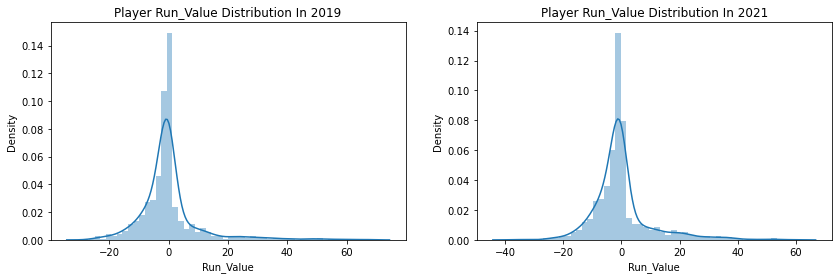

In [13]:
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
sns.distplot(player_ex_19['Run_Value'])
plt.title('Player Run_Value Distribution In 2019')

plt.subplot(1,2,2)
sns.distplot(player_ex_21['Run_Value'])
plt.title('Player Run_Value Distribution In 2021')

선수별 누적 Run Value 분포도를 시각화하였다. Top 20에서 볼 수 있었던 선수들의 Run Value는 실제로 매우 적은 분포인 것을 확인할 수 있었다. 대부분의 선수들은 0에 근접한 Run Value를 기록하였고, 0보다 작은 Run Value를 기록한 선수들도 상당수 있다는 것을 확인할 수 있었다. 
   
선수의 누적 Run Value가 높다는 것은 그만큼 득점에 기여하고 득점 기대값을 높였다는 것을 의미한다. 반대로 Run Value가 작다는 것은 그만큼 득점할 수 있는 기회에서 득점을 못하고, 득점 기대값을 낮추었다는 것을 의미한다.

## - 선수별 기회 대비 Run Value

누적 Run Value가 높다고 잘하는 선수라고 할 수 있을까? 선수마다 주어지는 득점권 찬스는 다르다. 극단적인 예를 들어서, 누군가는 항상 주자가 없는 상황에 타석에 들어설 수 있고, 반대로 누군가는 항상 만루 상황에 타석에 들어설 수 있다. 이 두 상황에서의 같은 안타나 2루타의 Run Value는 다르다.   
   
선수에게 득점권 찬스가 얼마나 주어졌나 확인하기 위해 득점 기대값을 활용하였다. 선수가 타석에 들어선 상황의 득점 기대값(Start_RE)의 누적수치를 통해 선수에게 얼마나 기회가 주어졌나를 가늠하였다. 그리고 선수별로 주어졌던 득점 기대값의 누적 수치와 Run Value의 누적 수치를 비교해서 선수에게 주어진 기회 대비 얼마나 많은 Run Value를 누적하였는가를 확인하였다.   
   
21시즌 400타석 이상 소화한 타자들에 대한 데이터를 이용하였다. 

In [14]:
re_21 = re21.copy()
player_ids = np.array(re_21['batter'])
batter = pyb.playerid_reverse_lookup(player_ids, key_type='mlbam')
batter['batter_name'] = batter['name_first'] + ' ' + batter['name_last']
batter_name = batter[['batter_name', 'key_mlbam']].rename(columns={'key_mlbam': 'batter'})
re_21 = pd.merge(re_21, batter_name, on='batter')

# 400타석 이상 기록한 선수들
pa_count = re_21.groupby('batter_name')['pitch_type'].count().reset_index()
batter_list = pa_count[pa_count['pitch_type']>=400]['batter_name']
pa_400 = re_21[re_21['batter_name'].isin(batter_list)]

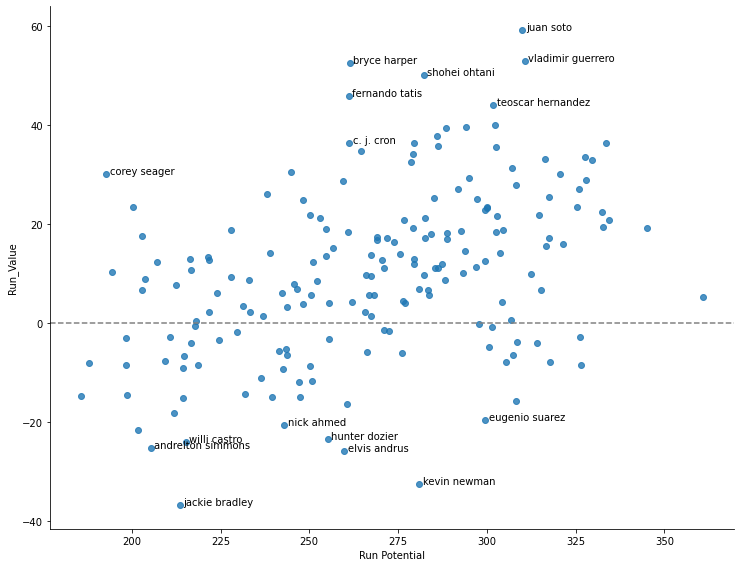

In [15]:
re_vs_rv = pa_400.groupby(['batter_name']).agg({'Start_RE': 'sum', 'Run_Value': 'sum'}).reset_index()
re_vs_rv['ratio'] = re_vs_rv['Run_Value']/re_vs_rv['Start_RE']
re_vs_rv['rratio'] = re_vs_rv['Start_RE']*re_vs_rv['Run_Value']
top_rv = re_vs_rv.sort_values(by='ratio', ascending=False).head(8)
bot_rv = re_vs_rv.sort_values(by='rratio').head(8)

# 시각화
ax = sns.lmplot('Start_RE', 'Run_Value', data=re_vs_rv, fit_reg=False, size=8, aspect=1.3)
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+1, point['y'], str(point['val']))
label_point(top_rv.Start_RE, top_rv.Run_Value, top_rv.batter_name, plt.gca())
label_point(bot_rv.Start_RE, bot_rv.Run_Value, bot_rv.batter_name, plt.gca()) 
plt.xlabel('Run Potential')
plt.axhline(0, color='grey', linestyle='--')
plt.show()

## - 토론토 블루제이스 타자들의 상황별 누적 Run Value

선수들 각각 어떤 상황에서 득점 기여를 더 잘하였고, 어떤 상황에서 득점 기회를 놓쳤는지 확인하기 위해 각 상황별 누적 Run Value를 표현하였다. 주자 득점권 상황에서 타자들의 performance를 확인할 수 있었다.   
    
토론토 블루제이스 타자들 3명을 예시로 들어 확인해보았다.

In [16]:
re_21['base_state'] = re_21['Start_State'].str.slice(stop=3)
player_value21_state = re_21.groupby(['batter_name', 'base_state']).agg({
    'pitch_type': 'count', 'Run_Value': 'sum', 'Run_Value': 'mean'}).reset_index().rename(columns={
    'pitch_type':'count', 'Run_Value': 'mean_RV'})
player_value21_state['total_RV'] = player_value21_state['count']*player_value21_state['mean_RV']

In [17]:
# vladimir guerrero
guerrero_rv = player_value21_state[player_value21_state['batter_name']=='vladimir guerrero'].sort_values(by='base_state')
guerrero_rv[['batter_name', 'base_state', 'count', 'mean_RV', 'total_RV']]

,batter_name,base_state,count,mean_RV,total_RV
5576,vladimir guerrero,000,386,0.065566,25.308512
5577,vladimir guerrero,001,14,0.10766,1.507235
5578,vladimir guerrero,010,74,0.104066,7.700902
5579,vladimir guerrero,011,9,-0.244659,-2.201927
5580,vladimir guerrero,100,133,0.082066,10.914815
5581,vladimir guerrero,101,17,0.356986,6.068755
5582,vladimir guerrero,110,47,0.079005,3.713217
5583,vladimir guerrero,111,11,-0.004567,-0.050232


In [18]:
# bo bichette
bichette_rv = player_value21_state[player_value21_state['batter_name']=='bo bichette'].sort_values(by='base_state')
bichette_rv[['batter_name', 'base_state', 'count', 'mean_RV', 'total_RV']]

,batter_name,base_state,count,mean_RV,total_RV
638,bo bichette,000,394,0.006029,2.375407
639,bo bichette,001,18,-0.056154,-1.010774
640,bo bichette,010,73,0.083665,6.107532
641,bo bichette,011,13,0.303361,3.943695
642,bo bichette,100,132,0.074274,9.804141
643,bo bichette,101,11,0.15663,1.722929
644,bo bichette,110,36,0.242322,8.723579
645,bo bichette,111,13,0.097207,1.263691


In [19]:
# 	george springer
springer_rv = player_value21_state[player_value21_state['batter_name']=='george springer'].sort_values(by='base_state')
springer_rv[['batter_name', 'base_state', 'count', 'mean_RV', 'total_RV']]

,batter_name,base_state,count,mean_RV,total_RV
1955,george springer,000,214,0.033278,7.12155
1956,george springer,001,5,-0.439781,-2.198905
1957,george springer,010,34,-0.015591,-0.530092
1958,george springer,011,7,0.143815,1.006706
1959,george springer,100,55,0.21767,11.971867
1960,george springer,101,4,-0.45851,-1.834039
1961,george springer,110,17,0.153184,2.604121
1962,george springer,111,5,0.387601,1.938003


## - Stat들과 Run_Value와의 상관 관계

In [20]:
stats_21 = pyb.batting_stats(2021)

In [21]:
st = stats_21[['IDfg', 'Season', 'RBI', 'AVG', 'SLG', 'BB/K', 'OPS', 'wOBA']]
id_list = np.array(st['IDfg'])
id_check = pyb.playerid_reverse_lookup(id_list, key_type='fangraphs')
id_merge = id_check[['key_mlbam', 'key_fangraphs']].rename(columns={'key_fangraphs': 'IDfg', 'key_mlbam': 'batter'})
st_21 = pd.merge(st, id_merge, on='IDfg')
player_ex_21_stat = pd.merge(player_ex_21, st_21, on='batter')

In [22]:
player_ex_21_stat['Run_Value'] = player_ex_21_stat['Run_Value'].astype('float64')

Text(0.5, 1.0, 'Run_Value vs BB/K In 2021')

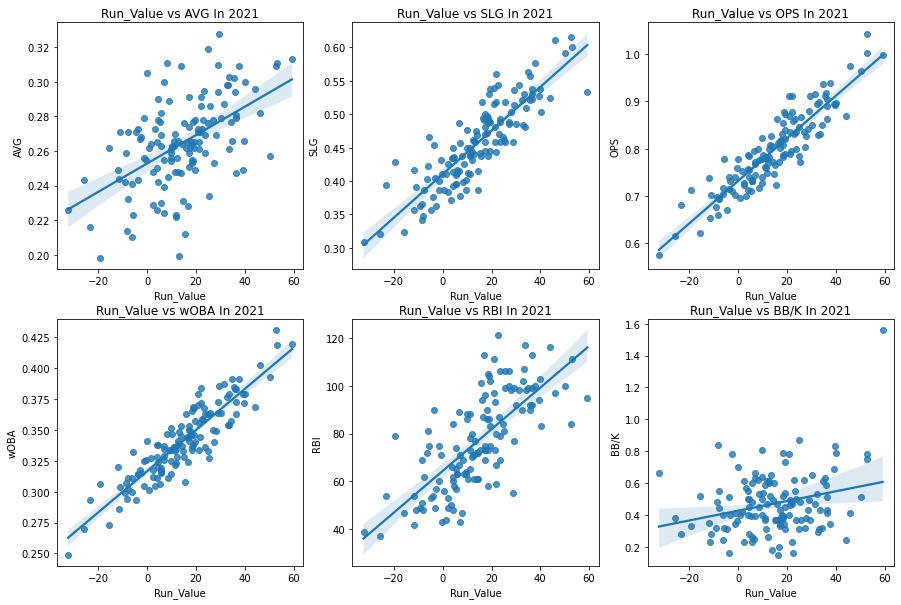

In [23]:
# 시각화
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
sns.regplot(data=player_ex_21_stat, x='Run_Value', y='AVG')
plt.title('Run_Value vs AVG In 2021')

plt.subplot(2,3,2)
sns.regplot(data=player_ex_21_stat, x='Run_Value', y='SLG')
plt.title('Run_Value vs SLG In 2021')

plt.subplot(2,3,3)
sns.regplot(data=player_ex_21_stat, x='Run_Value', y='OPS')
plt.title('Run_Value vs OPS In 2021')

plt.subplot(2,3,4)
sns.regplot(data=player_ex_21_stat, x='Run_Value', y='wOBA')
plt.title('Run_Value vs wOBA In 2021')

plt.subplot(2,3,5)
sns.regplot(data=player_ex_21_stat, x='Run_Value', y='RBI')
plt.title('Run_Value vs RBI In 2021')

plt.subplot(2,3,6)
sns.regplot(data=player_ex_21_stat, x='Run_Value', y='BB/K')
plt.title('Run_Value vs BB/K In 2021')

----

<a id="team"></a>
# 4. 팀별 누적 Run Value

팀별 누적 Run Value를 계산하였다. 선수 누적 Run Value와 유사하게, 각 팀의 **모든 타석에 대한 Run Value를 합산**하였다. 각 팀의 타자들이 얼마나 잘 득점하고 기회를 살리는지에 대한 득점 능력을 확인할 수 있었다.

In [24]:
# 팀별 누적 Run Value 계산

# 19시즌
re19['team']= np.where(re19['inning_topbot']=='Top',re19['away_team'],re19['home_team'])
team_value_19 = re19.groupby(['team'])['Run_Value'].sum().reset_index()
team_value_19 = team_value_19.sort_values(by='Run_Value', ascending=False)

# 21시즌
re21['team']= np.where(re21['inning_topbot']=='Top',re21['away_team'],re21['home_team'])
team_value_21 = re21.groupby(['team'])['Run_Value'].sum().reset_index()
team_value_21 = team_value_21.sort_values(by='Run_Value', ascending=False)

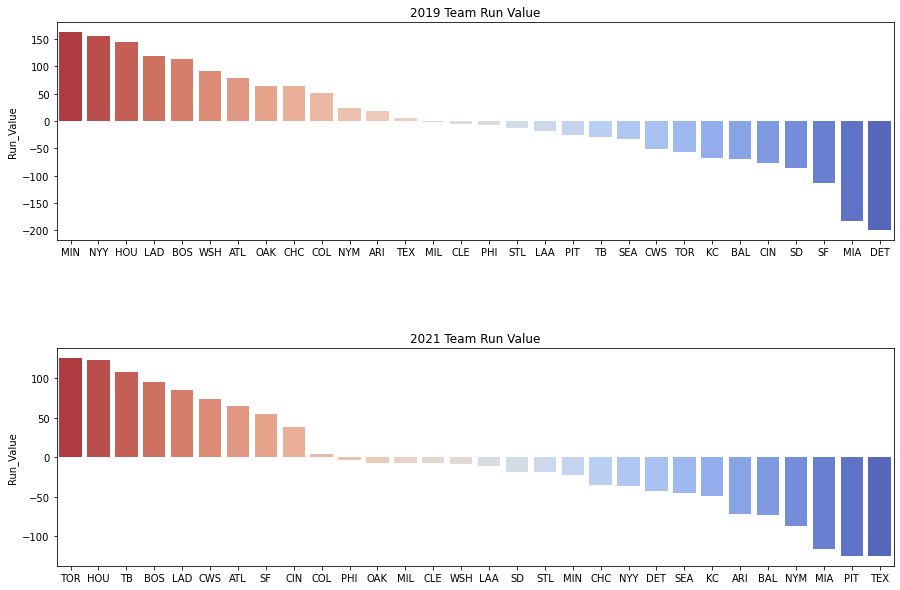

In [25]:
# 시각화

plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
sns.barplot(data=team_value_19, x='team', y='Run_Value', palette='coolwarm_r')
plt.title('2019 Team Run Value')
plt.xlabel('')

plt.subplot(2,1,2)
sns.barplot(data=team_value_21, x='team', y='Run_Value', palette='coolwarm_r')
plt.title('2021 Team Run Value')
plt.xlabel('')

plt.subplots_adjust(hspace=0.5)

19시즌에 누적 Run Value 1위 팀은 뉴욕 양키스(NYY)였고, 미네소타, 휴스턴, 다저스 등이 그 뒤를 이었다. 반대로 꼴등팀은 디트로이트로 누적 Run Value가 -200을 넘었다.

21시즌에 누적 Run Value 1위 팀은 류현진 선수가 소속되어 있는 토론토 블루제이스(TOR)였다. 그 뒤를 휴스턴, 템파베이, 보스턴이 뒤를 이었고, 19년에 1위였던 뉴욕양키스는 -36을 기록하며 중하위권에 있었다.

## - 팀별 Run Value와 팀 승률과의 관계성

팀의 Run Value가 높으면 승률이 좋을까? 야구는 점수가 높은 팀이 이기기 때문에 득점과 관련된 Run Value는 승률과 상관관계가 있을 것이라 예상하였다. 19시즌과 21시즌 팀의 승률 데이터를 불러와서 Run Value 데이터와 병합해 관계성을 확인해보았다.

In [26]:
# 팀들의 승률 데이터

# 19시즌
standing_19 = pyb.standings(2019)
team_total_19 = pd.DataFrame()
for i in range(len(standing_19)):
    team_total_19 = pd.concat([team_total_19, standing_19[i]])

# 21시즌
standing_21 = pyb.standings(2021)
team_total_21 = pd.DataFrame()
for i in range(len(standing_21)):
    team_total_21 = pd.concat([team_total_21, standing_21[i]])

In [27]:
team_total_19['team']=''
team_total_21['team']=''
def team_name(team):
    team['team'] = np.where(team['Tm']=='New York Yankees', 'NYY', '')
    team['team'] = np.where(team['Tm']=='Tampa Bay Rays', 'TB', team['team'])
    team['team'] = np.where(team['Tm']=='Boston Red Sox', 'BOS', team['team'])
    team['team'] = np.where(team['Tm']=='Toronto Blue Jays', 'TOR', team['team'])
    team['team'] = np.where(team['Tm']=='Baltimore Orioles', 'BAL', team['team'])
    team['team'] = np.where(team['Tm']=='Minnesota Twins', 'MIN', team['team'])
    team['team'] = np.where(team['Tm']=='Cleveland Indians', 'CLE', team['team'])
    team['team'] = np.where(team['Tm']=='Chicago White Sox', 'CWS', team['team'])
    team['team'] = np.where(team['Tm']=='Kansas City Royals', 'KC', team['team'])
    team['team'] = np.where(team['Tm']=='Detroit Tigers', 'DET', team['team'])
    team['team'] = np.where(team['Tm']=='Houston Astros', 'HOU', team['team'])
    team['team'] = np.where(team['Tm']=='Oakland Athletics', 'OAK', team['team'])
    team['team'] = np.where(team['Tm']=='Texas Rangers', 'TEX', team['team'])
    team['team'] = np.where(team['Tm']=='Los Angeles Angels', 'LAA', team['team'])
    team['team'] = np.where(team['Tm']=='Seattle Mariners', 'SEA', team['team'])
    team['team'] = np.where(team['Tm']=='Atlanta Braves', 'ATL', team['team'])
    team['team'] = np.where(team['Tm']=='Washington Nationals', 'WSH', team['team'])
    team['team'] = np.where(team['Tm']=='New York Mets', 'NYM', team['team'])
    team['team'] = np.where(team['Tm']=='Philadelphia Phillies', 'PHI', team['team'])
    team['team'] = np.where(team['Tm']=='Miami Marlins', 'MIA', team['team'])
    team['team'] = np.where(team['Tm']=='St. Louis Cardinals', 'STL', team['team'])
    team['team'] = np.where(team['Tm']=='Milwaukee Brewers', 'MIL', team['team'])
    team['team'] = np.where(team['Tm']=='Chicago Cubs', 'CHC', team['team'])
    team['team'] = np.where(team['Tm']=='Cincinnati Reds', 'CIN', team['team'])
    team['team'] = np.where(team['Tm']=='Pittsburgh Pirates', 'PIT', team['team'])
    team['team'] = np.where(team['Tm']=='Los Angeles Dodgers', 'LAD', team['team'])
    team['team'] = np.where(team['Tm']=='Arizona Diamondbacks', 'ARI', team['team'])
    team['team'] = np.where(team['Tm']=='San Francisco Giants', 'SF', team['team'])
    team['team'] = np.where(team['Tm']=='Colorado Rockies', 'COL', team['team'])
    team['team'] = np.where(team['Tm']=='San Diego Padres', 'SD', team['team'])  
    return team

In [28]:
# Run_Value 데이터와 승률 데이터 병합
team_total_19_ = team_name(team_total_19)[['team', 'W', 'L', 'W-L%']]
team_total_21_ = team_name(team_total_21)[['team', 'W', 'L', 'W-L%']]
team_19 = pd.merge(team_total_19_, team_value_19, on='team')
team_21 = pd.merge(team_total_21_, team_value_21, on='team')
team_19['W-L%'] = team_19['W-L%'].astype('float')
team_21['W-L%'] = team_21['W-L%'].astype('float')

Text(0.5, 1.0, 'Run_Value vs W-L% In 2021')

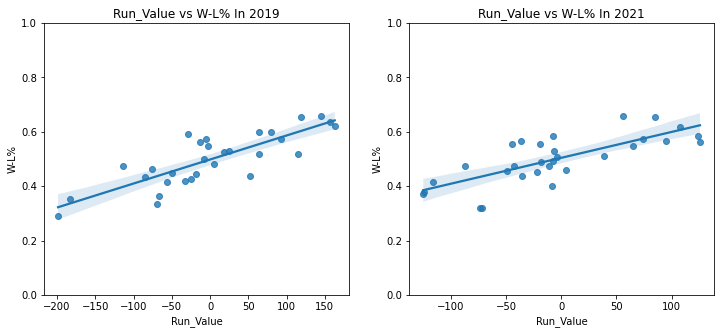

In [29]:
team_19['Run_Value'] = team_19['Run_Value'].astype('float64')
team_21['Run_Value'] = team_21['Run_Value'].astype('float64')
# 시각화
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.regplot(data=team_19, x='Run_Value', y='W-L%')
plt.ylim(0,1)
plt.title('Run_Value vs W-L% In 2019')

plt.subplot(1,2,2)
sns.regplot(data=team_21, x='Run_Value', y='W-L%')
plt.ylim(0,1)
plt.title('Run_Value vs W-L% In 2021')

In [30]:
import statsmodels.formula.api as smf

# 19시즌 선형회귀
team_19_fix = team_19.rename(columns={'W-L%': 'WL_percent'})
reg_19 = smf.ols(formula = 'WL_percent ~ Run_Value', data=team_19_fix).fit()
reg_19.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             WL_percent   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     59.91
Date:                Tue, 12 Apr 2022   Prob (F-statistic):           1.97e-08
Time:                        00:45:50   Log-Likelihood:                 44.798
No. Observations:                  30   AIC:                            -85.60
Df Residuals:                      28   BIC:                            -82.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4982      0.010     48.484      0.000       0.477       0.519
Run_Value      0.0009      0.000      7.740      0.000       0.001       0.001
==============================================================================
Omnibus:                        0.016   Durbin-Watson:                   2.223
Prob(Omnibus):                  0.992   Jarque-Bera (JB):                0.206
Skew:                          -0.006   Prob(JB):                        0.902
Kurtosis:                       2.595   Cond. No.                         90.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# 21시즌 선형회귀
team_21_fix = team_21.rename(columns={'W-L%': 'WL_percent'})
reg_21 = smf.ols(formula = 'WL_percent ~ Run_Value', data=team_21_fix).fit()
reg_21.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             WL_percent   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     37.53
Date:                Tue, 12 Apr 2022   Prob (F-statistic):           1.30e-06
Time:                        00:45:50   Log-Likelihood:                 43.181
No. Observations:                  30   AIC:                            -82.36
Df Residuals:                      28   BIC:                            -79.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5043      0.011     46.421      0.000       0.482       0.527
Run_Value      0.0010      0.000      6.126      0.000       0.001       0.001
==============================================================================
Omnibus:                        0.005   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.998   Jarque-Bera (JB):                0.173
Skew:                           0.009   Prob(JB):                        0.917
Kurtosis:                       2.628   Cond. No.                         70.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

선형회귀 분석을 통해 승률과 Run Value가 유의미한 상관관계를 가지고 있다는 것을 확인하였다. 19시즌에는 Run Value가 1증가할때마다 평균적으로 승률이 0.0009 증가하였고, 21시즌에는 Run Value가 1증가할때마다 평균적으로 승률이 0.001증가하였다. 이 둘의 분석 결과를 바탕으로, 대략적으로 Run Value가 1 증가하면 승률은 0.1% 포인트 상승한다는 것을 확인할 수 있었다.
   
R스퀘어는 19시즌 0.68, 21시즌 0.57 정도가 측정되었다. 이는 Run Value의 분산 약 60%정도가 승률의 분산을 표현한다고 볼 수 있다. R스퀘어가 1에 가까울만큼 크지 않은 이유는 '득점'만이 승리를 결정하지 않기 때문이다. 득점만큼이나 실점 또한 승리를 결정하는 주요 요인이기 때문에, 득점만 고려한 Run Value만으로는 승률을 완벽하게 예측하지 못하였다.